In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import product
from torch.nn import functional, MaxPool2d
from torch import Tensor
from PIL import Image

# **ECAL Channel**
---
Exploration of the electromagnetic calorimeter, which measures energy deposits from electromagnetic particles

In [2]:
random_jets = np.random.randint(0, 20000, 8)

In [3]:
batch_size: int = 10000
n_samples: int = 45000
n_batches: int = int(n_samples/batch_size)
jets_ECAL_gluon: np.array = np.empty((0, 125, 125))
pt_gluon: np.array = np.empty(0)

for i in range(n_batches):
    with h5py.File("/home/reyguadarrama/GSoC/data/quark-gluon_test-set_n139306.hdf5", 'r') as file:
        jets = file.get('X_jets')[batch_size*i:batch_size*(i+1)][:,:,:,1]
        moment_t = file.get('pt')[batch_size*i:batch_size*(i+1)]
        label = file.get('y')[batch_size*i:batch_size*(i+1)]

        indices_gluon = np.where(label == 0)[0]
        
        jets_ECAL_gluon = np.concatenate((jets_ECAL_gluon, jets[indices_gluon]))

        pt_gluon = np.concatenate((pt_gluon, moment_t[indices_gluon]))

## **Raw images**

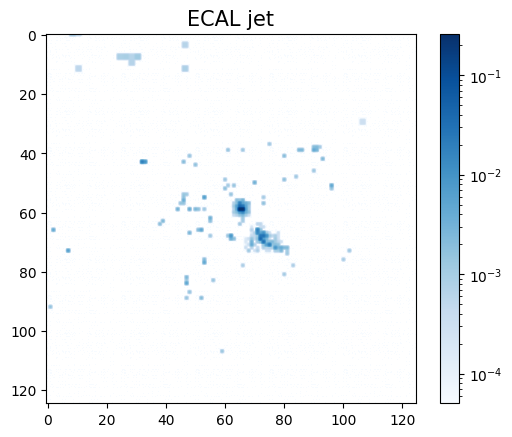

In [4]:
plt.imshow(jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

In [11]:
print(jets_ECAL_gluon.shape)

(19975, 125, 125)


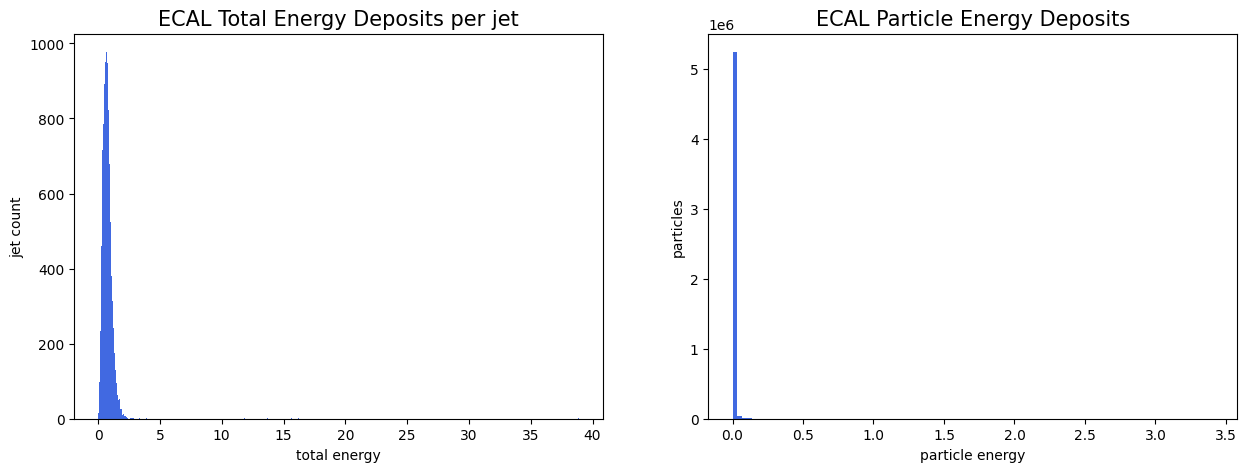

In [30]:
# Sum of the energy deposits of all particles in each individual jet
total_energy_per_jet = np.sum(jets_ECAL_gluon, axis=(1, 2))
particles_energy_deposits = jets_ECAL_gluon[jets_ECAL_gluon > 0]


fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(total_energy_per_jet, bins=1000, color="royalblue")
axs[0].set_title("ECAL Total Energy Deposits per jet", fontsize=15)
axs[0].set_xlabel("total energy")
axs[0].set_ylabel("jet count")

axs[1].hist(particles_energy_deposits, bins=100, color="royalblue")
axs[1].set_title("ECAL Particle Energy Deposits", fontsize=15)
axs[1].set_xlabel("particle energy")
axs[1].set_ylabel("particles")

plt.show()

## **Cropped images**

In [12]:
cropped_jets_ECAL_gluon = jets_ECAL_gluon[:,22:102, 22:102]

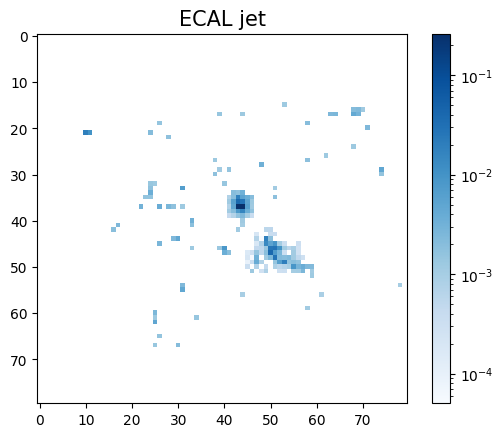

In [13]:
plt.imshow(cropped_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

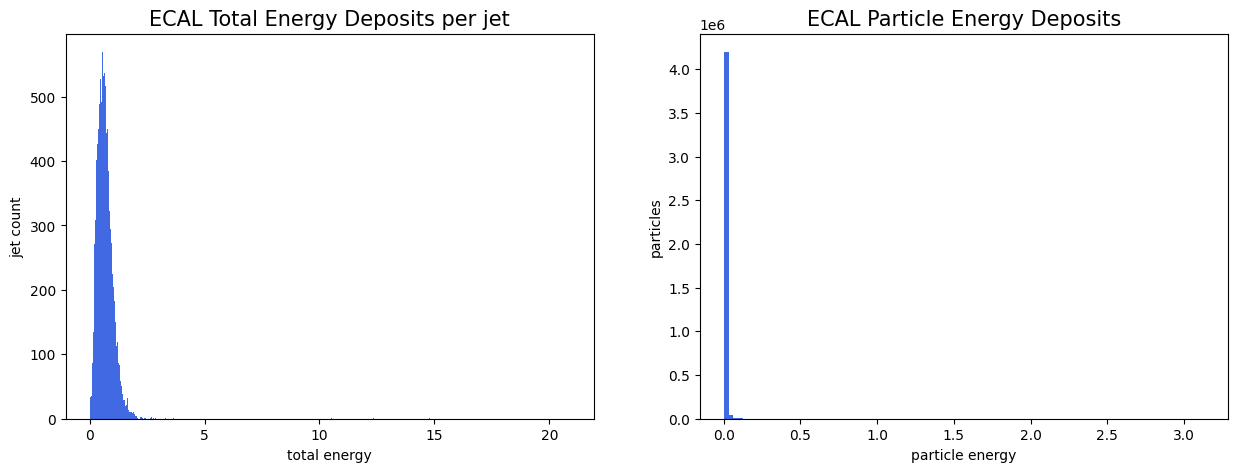

In [31]:
# Sum of the energy deposits of all particles in each individual jet
total_energy_per_cropped_jet = np.sum(cropped_jets_ECAL_gluon, axis=(1, 2))
particles_energy_deposits_cropped_jet = cropped_jets_ECAL_gluon[cropped_jets_ECAL_gluon > 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(total_energy_per_cropped_jet, bins=1000, color="royalblue")
axs[0].set_title("ECAL Total Energy Deposits per jet", fontsize=15)
axs[0].set_xlabel("total energy")
axs[0].set_ylabel("jet count")

axs[1].hist(particles_energy_deposits_cropped_jet, bins=100, color="royalblue")
axs[1].set_title("ECAL Particle Energy Deposits", fontsize=15)
axs[1].set_xlabel("particle energy")
axs[1].set_ylabel("particles")

plt.show()

## **Cropped and Resized Images**

#### **Bilinear interpolation**

In [41]:
bilinear_jets_ECAL_gluon = (functional.interpolate(Tensor(cropped_jets_ECAL_gluon).unsqueeze(1), size=(8, 8), mode="bilinear", antialias=True)).squeeze(1).numpy()

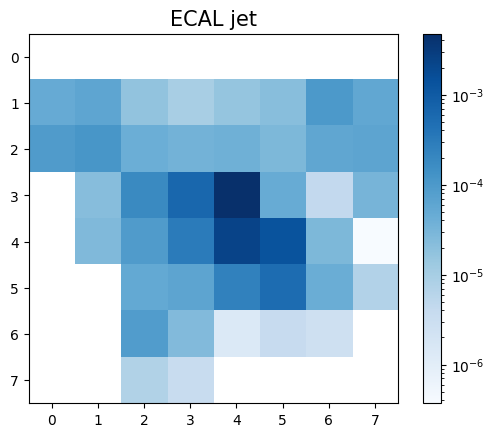

In [42]:
plt.imshow(bilinear_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

In [43]:
bilinear_jets_total_energy = np.sum(bilinear_jets_ECAL_gluon, axis=(1, 2))

#### **Bicubic Interpolation**

In [44]:
bicubic_jets_ECAL_gluon = (functional.interpolate(Tensor(cropped_jets_ECAL_gluon).unsqueeze(1), size=(8, 8), mode="bicubic", antialias=True)).squeeze(1).numpy()

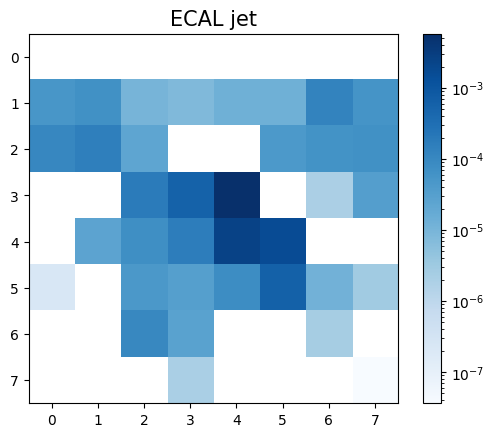

In [45]:
plt.imshow(bicubic_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

In [46]:
bicubic_jets_total_energy = np.sum(bicubic_jets_ECAL_gluon, axis=(1, 2))

#### **Max Pooling**

In [70]:
m = MaxPool2d(10, stride=10)
maxpool_jets_ECAL_gluon = (m(Tensor(cropped_jets_ECAL_gluon).unsqueeze(1))).squeeze(1).numpy()

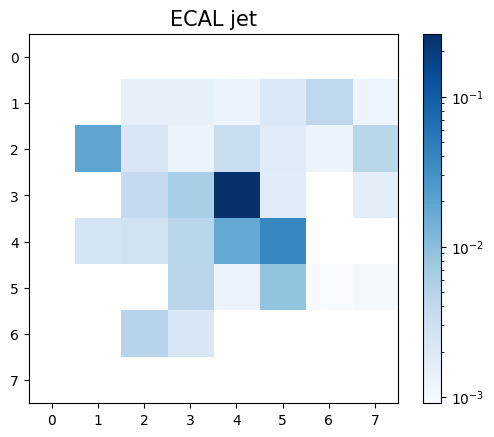

In [71]:
plt.imshow(maxpool_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

In [72]:
maxpool_jets_total_energy = np.sum(maxpool_jets_ECAL_gluon, axis=(1, 2))

#### **Sum Pooling**

In [18]:
def sum_pooling(input, kernel_size):
    batch_size, channels, height, width = input.size()
    
    unfolded = functional.unfold(input, kernel_size=kernel_size, stride=kernel_size)
    
    summed = unfolded.view(batch_size, channels, kernel_size * kernel_size, -1).sum(dim=2)
    
    output = summed.view(batch_size, channels, height // kernel_size, width // kernel_size)
    
    return output

sumpool_jets_ECAL_gluon = sum_pooling(Tensor(cropped_jets_ECAL_gluon).unsqueeze(1), kernel_size=10).squeeze(1).numpy()


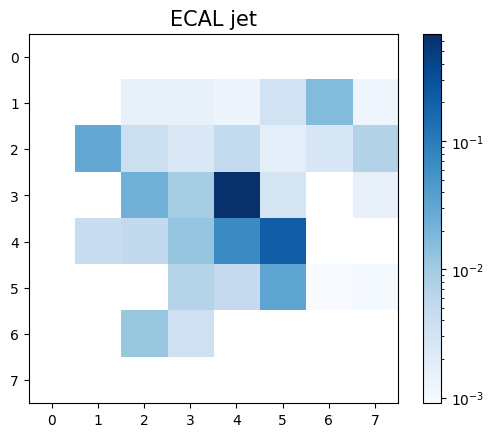

In [19]:
plt.imshow(sumpool_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

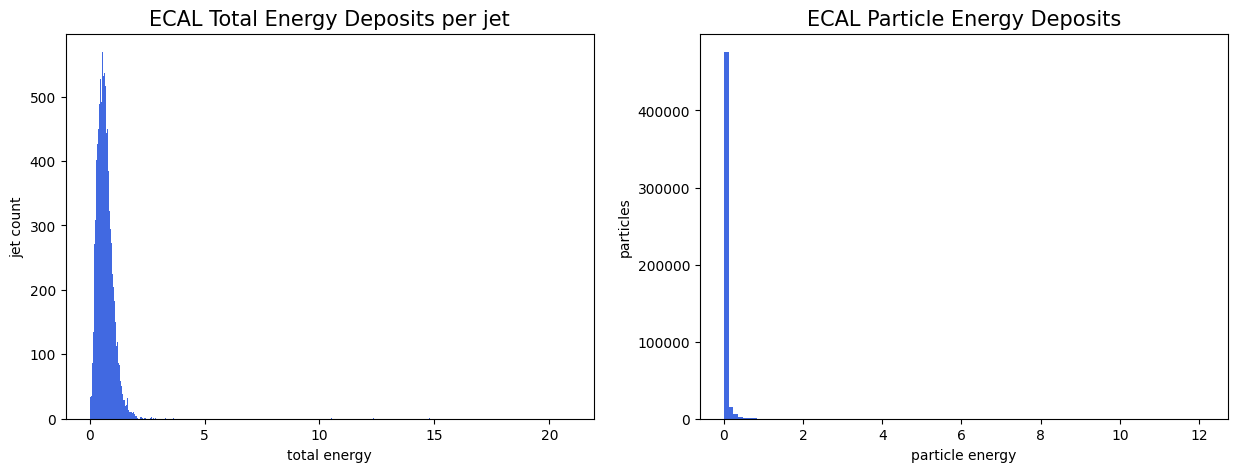

In [32]:
sumpool_jets_total_energy = np.sum(sumpool_jets_ECAL_gluon, axis=(1, 2))
sumpool_particles_energy_deposits = sumpool_jets_ECAL_gluon[sumpool_jets_ECAL_gluon > 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(sumpool_jets_total_energy, bins=1000, color="royalblue")
axs[0].set_title("ECAL Total Energy Deposits per jet", fontsize=15)
axs[0].set_xlabel("total energy")
axs[0].set_ylabel("jet count")

axs[1].hist(sumpool_particles_energy_deposits, bins=100, color="royalblue")
axs[1].set_title("ECAL Particle Energy Deposits", fontsize=15)
axs[1].set_xlabel("particle energy")
axs[1].set_ylabel("particles")

plt.show()

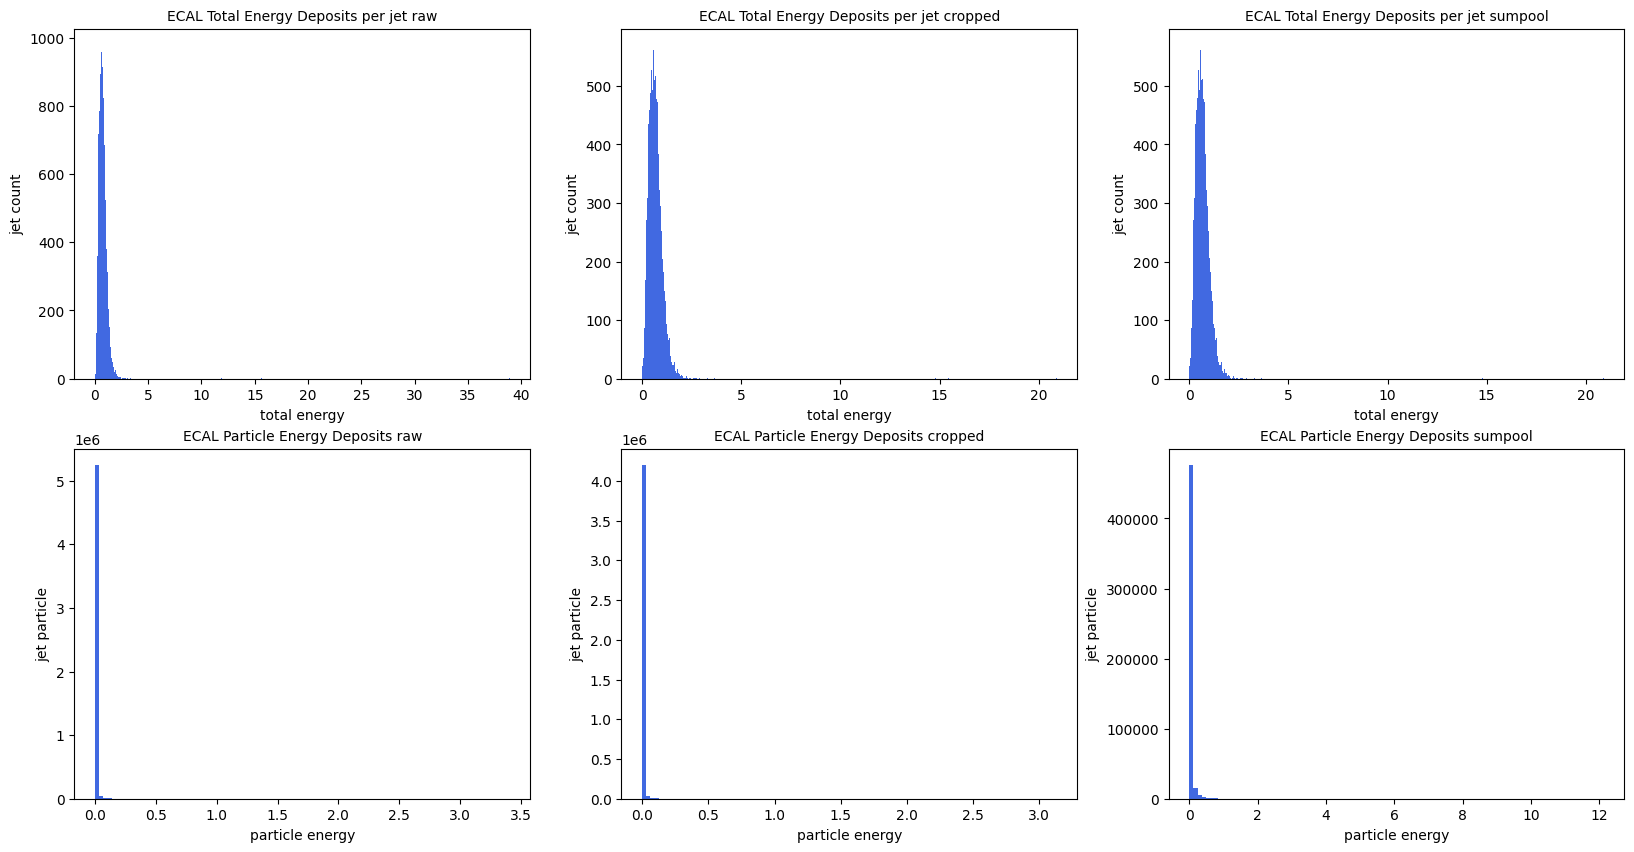

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

axs[0, 0].hist(total_energy_per_jet, bins=1000, color="royalblue")
axs[0, 0].set_title("ECAL Total Energy Deposits per jet raw", fontsize=10)
axs[0, 0].set_xlabel("total energy")
axs[0, 0].set_ylabel("jet count")

axs[1, 0].hist(particles_energy_deposits, bins=100, color="royalblue")
axs[1, 0].set_title("ECAL Particle Energy Deposits raw", fontsize=10)
axs[1, 0].set_xlabel("particle energy")
axs[1, 0].set_ylabel("particle")

axs[0, 1].hist(total_energy_per_cropped_jet, bins=1000, color="royalblue")
axs[0, 1].set_title("ECAL Total Energy Deposits per jet cropped", fontsize=10)
axs[0, 1].set_xlabel("total energy")
axs[0, 1].set_ylabel("jet count")

axs[1, 1].hist(particles_energy_deposits_cropped_jet, bins=100, color="royalblue")
axs[1, 1].set_title("ECAL Particle Energy Deposits cropped", fontsize=10)
axs[1, 1].set_xlabel("particle energy")
axs[1, 1].set_ylabel("particle")

axs[0, 2].hist(sumpool_jets_total_energy, bins=1000, color="royalblue")
axs[0, 2].set_title("ECAL Total Energy Deposits per jet sumpool", fontsize=10)
axs[0, 2].set_xlabel("total energy")
axs[0, 2].set_ylabel("jet count")

axs[1, 2].hist(sumpool_particles_energy_deposits, bins=100, color="royalblue")
axs[1, 2].set_title("ECAL Particle Energy Deposits sumpool", fontsize=10)
axs[1, 2].set_xlabel("particle energy")
axs[1, 2].set_ylabel("particle")

plt.show()

#### **Max-Min Normalization**

In [76]:
normalized_jets_ECAL_gluon = np.empty_like(sumpool_jets_ECAL_gluon)

for i in range(sumpool_jets_ECAL_gluon.shape[0]):
    data_min = np.min(sumpool_jets_ECAL_gluon[i])
    data_max = np.max(sumpool_jets_ECAL_gluon[i])
    if data_max != 0:
        normalized_jets_ECAL_gluon[i] = (sumpool_jets_ECAL_gluon[i] - data_min) / (data_max - data_min)

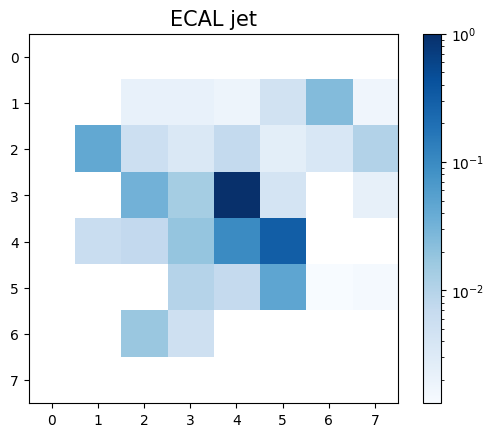

In [77]:
plt.imshow(normalized_jets_ECAL_gluon[1], cmap="Blues", norm=mcolors.LogNorm())
plt.title("ECAL jet", fontsize=15)
plt.colorbar()
plt.show()

In [78]:
normalized_jets_total_energy = np.sum(normalized_jets_ECAL_gluon, axis=(1, 2))

## **Comparison**

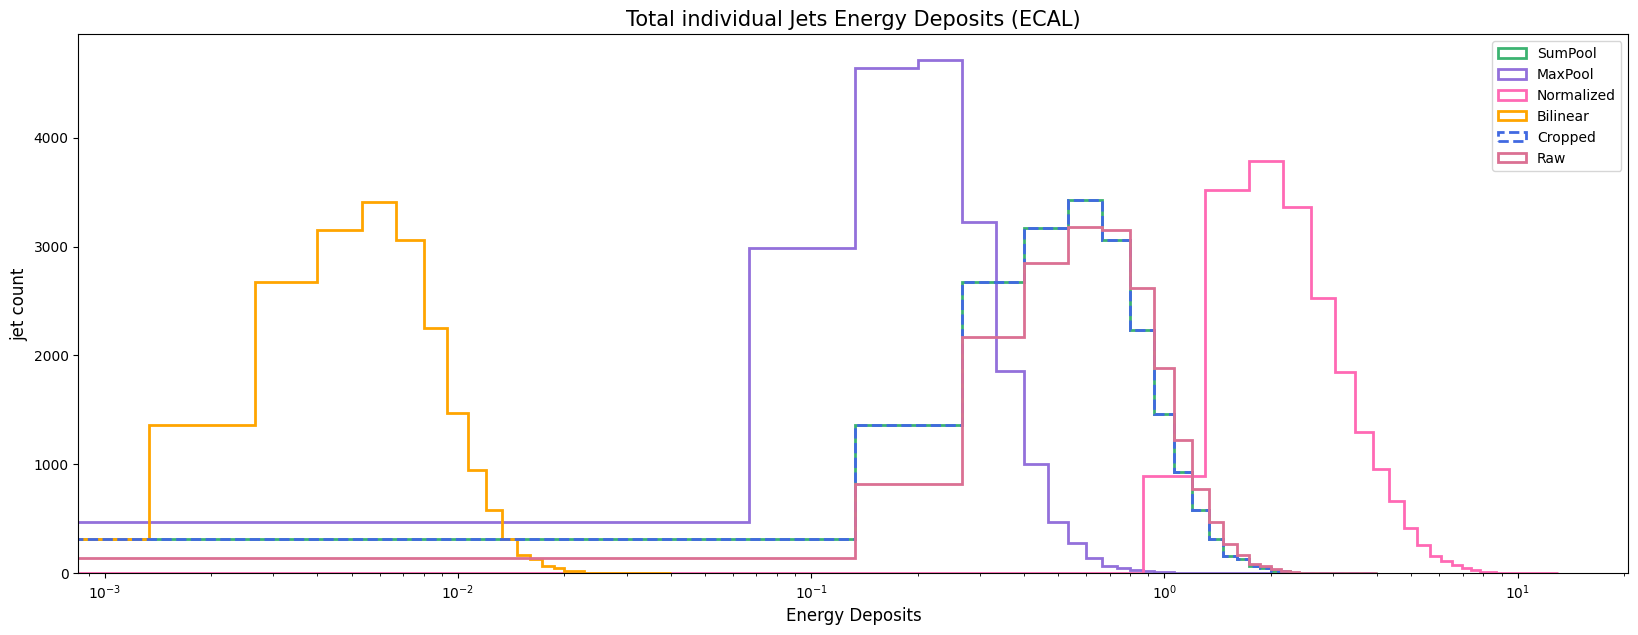

In [97]:
fig, ax = plt.subplots(1, figsize=(20, 7)) 

ax.hist(sumpool_jets_total_energy, bins=30, range=(0, 4), label="SumPool", histtype="step", linewidth=2, color="mediumseagreen")
ax.hist(maxpool_jets_total_energy, bins=30, range=(0, 2), label="MaxPool", histtype="step", linewidth=2, color="mediumpurple")
ax.hist(normalized_jets_total_energy, bins=30, range=(0, 13), label="Normalized", histtype="step", linewidth=2, color="hotpink")
ax.hist(bilinear_jets_total_energy, bins=30, range=(0, 0.04), label="Bilinear", histtype="step", linewidth=2, color="orange")
ax.hist(total_energy_per_cropped_jet, bins=30, range=(0, 4), label="Cropped", histtype="step", linewidth=2, linestyle="--", color="royalblue")
ax.hist(total_energy_per_jet, bins=30, range=(0, 4), label="Raw", histtype="step", linewidth=2, color="palevioletred")
ax.set_xscale("log")
ax.set_title("Total individual Jets Energy Deposits (ECAL)", fontsize=15)
ax.set_xlabel("Energy Deposits", fontsize=12)
ax.set_ylabel("jet count", fontsize=12)

plt.legend()
plt.show()

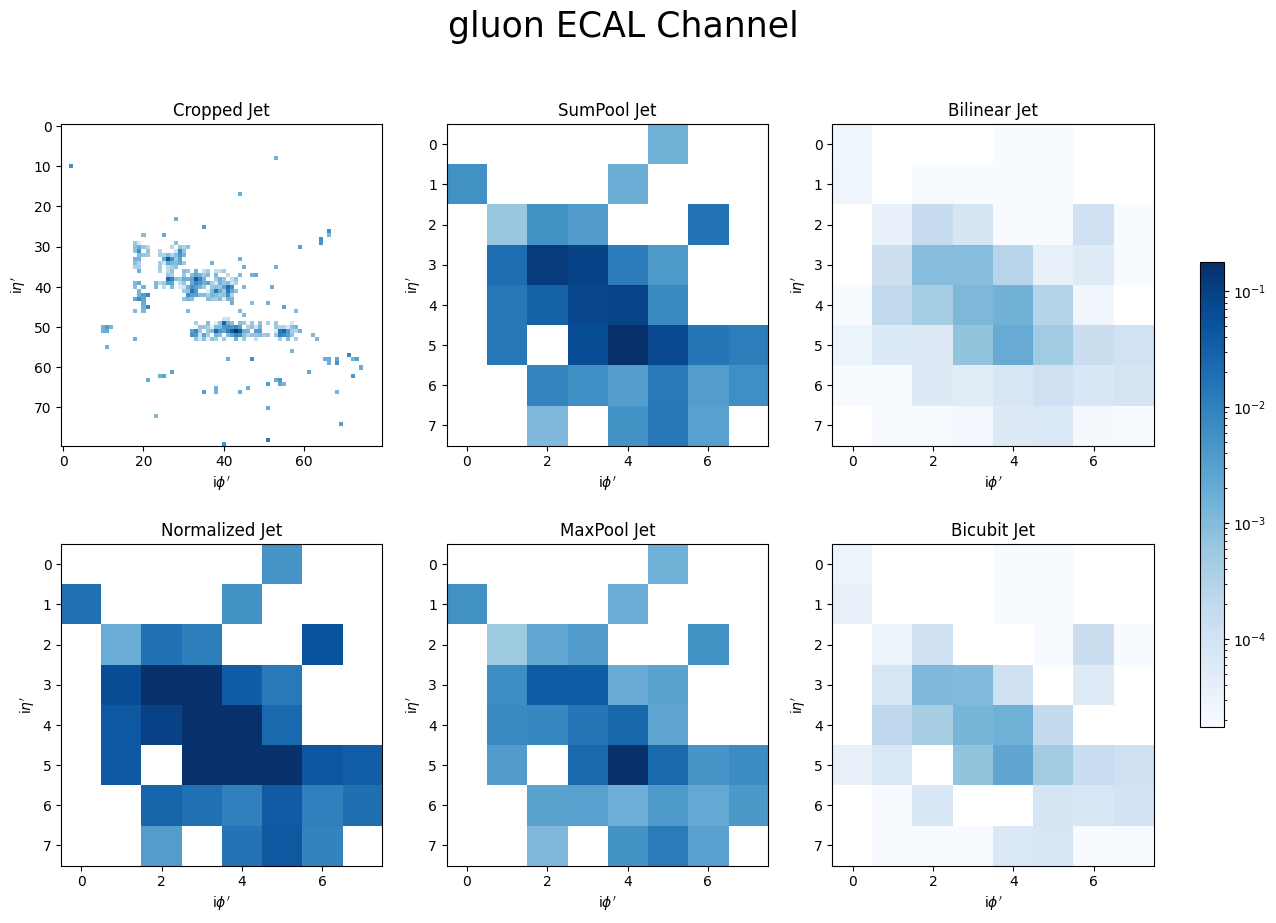

In [80]:
norm = mcolors.LogNorm()

fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 

im1 = axs[0, 0].imshow(cropped_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[0, 0].set_title("Cropped Jet")


im2 = axs[1, 0].imshow(normalized_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[1, 0].set_title("Normalized Jet")


im3 = axs[0, 1].imshow(sumpool_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[0, 1].set_title("SumPool Jet")


im4 = axs[1, 1].imshow(maxpool_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[1, 1].set_title("MaxPool Jet")


im5 = axs[0, 2].imshow(bilinear_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[0, 2].set_title("Bilinear Jet")


im6 = axs[1, 2].imshow(bicubic_jets_ECAL_gluon[0], cmap="Blues", norm=norm)
axs[1, 2].set_title("Bicubit Jet")


for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle("gluon ECAL Channel", fontsize=25)
plt.show()

In [81]:
mean_cropped_jets_ECAL_gluon = np.mean(cropped_jets_ECAL_gluon, axis=0)
mean_normalized_jets_ECAL_gluon = np.mean(normalized_jets_ECAL_gluon, axis=0)
mean_sumpool_jets_ECAL_gluon = np.mean(sumpool_jets_ECAL_gluon, axis=0)
mean_maxpool_jets_ECAL_gluon = np.mean(maxpool_jets_ECAL_gluon, axis=0)
mean_bilinear_jets_ECAL_gluon = np.mean(bilinear_jets_ECAL_gluon, axis=0)
mean_bicubic_jets_ECAL_gluon = np.mean(bicubic_jets_ECAL_gluon, axis=0)

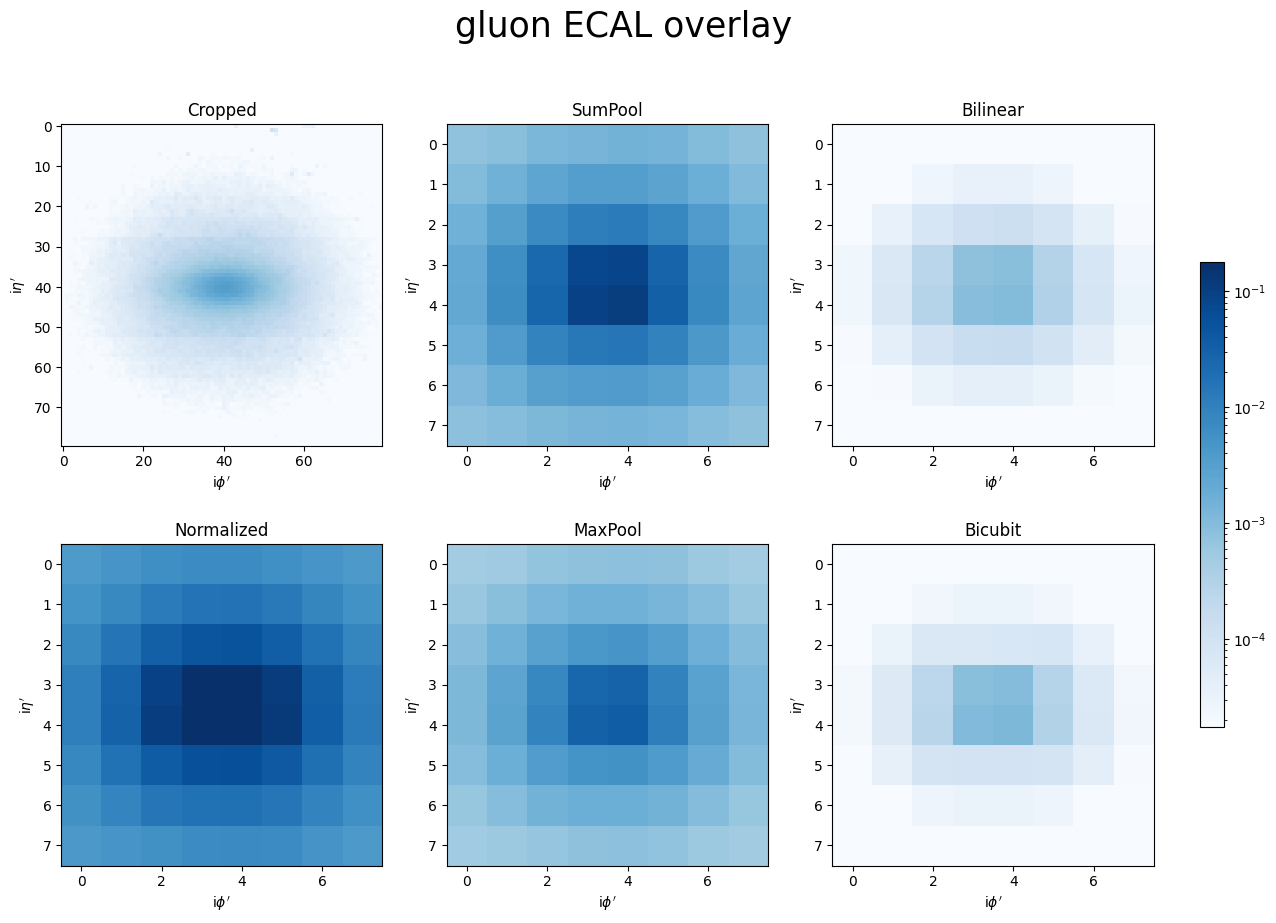

In [82]:

fig, axs = plt.subplots(2, 3, figsize=(15, 10)) 

im1 = axs[0, 0].imshow(mean_cropped_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[0, 0].set_title("Cropped")


im2 = axs[1, 0].imshow(mean_normalized_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[1, 0].set_title("Normalized")


im3 = axs[0, 1].imshow(mean_sumpool_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[0, 1].set_title("SumPool")


im4 = axs[1, 1].imshow(mean_maxpool_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[1, 1].set_title("MaxPool")


im5 = axs[0, 2].imshow(mean_bilinear_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[0, 2].set_title("Bilinear")


im6 = axs[1, 2].imshow(mean_bicubic_jets_ECAL_gluon, cmap="Blues", norm=norm)
axs[1, 2].set_title("Bicubit")


for ax in axs.flat:
    ax.set(xlabel="i$\phi '$", ylabel="i$\eta '$")

cbar = fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

plt.suptitle("gluon ECAL overlay", fontsize=25)
plt.show()